In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.calibration import cross_val_predict
from sklearn.neural_network import MLPClassifier

import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE


In [2]:
dataset = pd.read_csv('data/2022-feature-dataset.csv')
X = dataset.drop('Resultado',axis=1)
dataset['Resultado'] = dataset.apply(lambda row: 1 if row['Resultado'] == 'Positivo' else 0,axis=1)

y = dataset['Resultado']


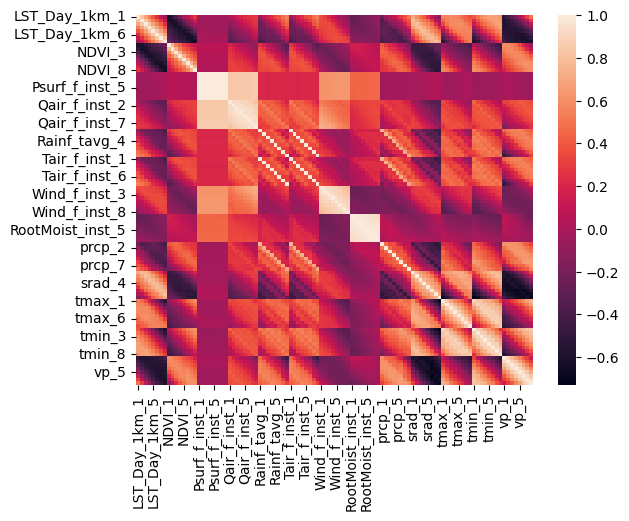

In [3]:
import seaborn as sn
import matplotlib.pyplot as plt

sn.heatmap(X.corr())
plt.show()

In [4]:
from sklearn.impute import SimpleImputer


imp = SimpleImputer(strategy="mean")
X_ = pd.DataFrame(imp.fit_transform(X), columns=X.columns)


In [5]:

def training_test(clf,X,y):
    smote = SMOTE()
    #clf = svm.SVC(C=1.0, kernel='poly', degree=3, gamma=2)
    #clf = lgb.LGBMClassifier()
    #clf = MLPClassifier()

    X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.25, shuffle=True, random_state=1337, stratify=y)
    X_smote, y_smote = smote.fit_resample(X_train, y_train)

    skf = StratifiedKFold(n_splits=5)

    y_ = cross_val_predict(clf,X_smote,y_smote, cv=skf)

    print(accuracy_score(y_smote,y_))
    print(precision_score(y_smote,y_, average="binary", pos_label=1))
    print(recall_score(y_smote,y_, average="binary", pos_label=1))
    print(confusion_matrix(y_smote,y_,labels=[1,0]))

    clf.fit(X_smote, y_smote)
    y_ = clf.predict(X_test)

    print(accuracy_score(y_test,y_))
    print(precision_score(y_test,y_, average="binary", pos_label=1))
    print(recall_score(y_test,y_, average="binary", pos_label=1))
    print(confusion_matrix(y_test,y_,labels=[1,0]))

    y_prob = clf.predict_proba(X_test)
    return accuracy_score(y_test,y_),recall_score(y_test,y_, average="binary", pos_label=0.0), \
        recall_score(y_test,y_, average="binary", pos_label=1.0)




In [6]:
from sklearn.ensemble import RandomForestClassifier


training_test(lgb.LGBMClassifier(),X_,y)

[LightGBM] [Info] Number of positive: 5636, number of negative: 5636
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26520
[LightGBM] [Info] Number of data points in the train set: 11272, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 5636, number of negative: 5636
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26520
[LightGBM] [Info] Number of data points in the train set: 11272, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 5636, number of negative: 5636
[LightGBM] [Info] Auto-choosing col-wise multi-thread

(0.8829249319331, 0.9203577512776832, 0.48878923766816146)

In [ ]:
results = pd.DataFrame(columns=['Algorithm','Accuracy','RecallN','RecallP'])
for column in X_:
    print(column)
    acc,rn,rp = training_test(xgb.XGBClassifier(),pd.DataFrame(X_[column]),y)
    row = [column,acc,rn,rp]
    results.loc[len(results)] = row
    

results.to_csv('data/each-col.csv')

In [7]:
from sklearn.model_selection import GridSearchCV


param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1]
}
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X_, y)
xgb_model = xgb.XGBClassifier()
grid_search = GridSearchCV(xgb_model, param_grid, cv=10, scoring='recall')
grid_search.fit(X_smote, y_smote)
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)


KeyboardInterrupt: 

In [88]:
#clf = xgb_model = xgb.XGBClassifier(**grid_search.best_params_)
clf = grid_search.best_estimator_
training_test(clf,X_,y)

0.8999248496993988
0.8711064621106462
0.93875250501002
[[7495  489]
 [1109 6875]]
0.8418664938431627
0.29927007299270075
0.6119402985074627
[[  82   52]
 [ 192 1217]]


(0.8418664938431627, 0.8637331440738112, 0.6119402985074627)

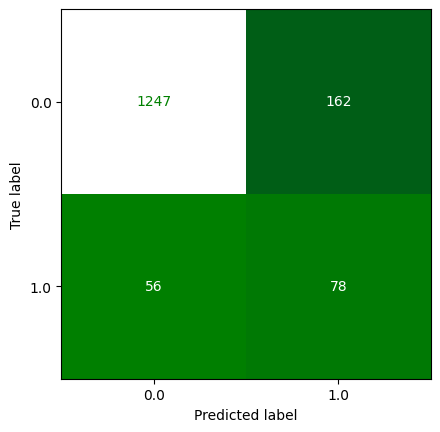

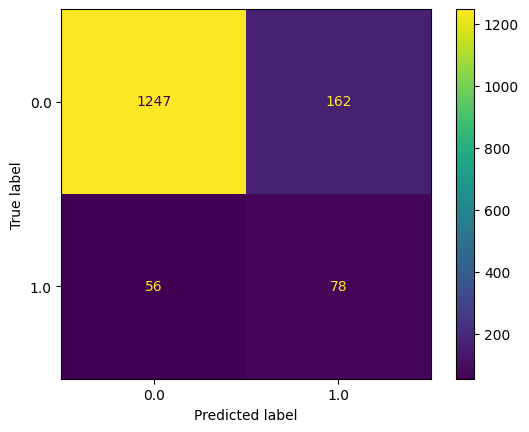

In [137]:
cm = confusion_matrix(y_test,y_, labels=clf.classes_)
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,y_,colorbar=False,cmap='ocean')
disp.plot()

[0.041863177, 0.91494095, 0.018149966, 0.4714013, 0.016206939, 0.13342744, 0.023103338, 0.019821433, 0.06737531, 0.00951403, 0.071707584, 0.11063154, 0.8924211, 0.04639183, 0.060202483, 0.21192518, 0.05749195, 0.13628258, 0.51287043, 0.0067513753, 0.7033458, 0.24914259, 0.044229127, 0.031911228, 0.0131701585, 0.07348909, 0.83985686, 0.58072233, 0.9613256, 0.418814, 0.7846989, 0.13074805, 0.8060786, 0.16411419, 0.005371671, 0.10518293, 0.4301208, 0.07750506, 0.03455216, 0.05460756, 0.019756014, 0.01397424, 0.03656046, 0.7794567, 0.1645421, 0.3906453, 0.4307506, 0.059785005, 0.0044650915, 0.30017957, 0.8516438, 0.013652642, 0.052977286, 0.045463737, 0.690424, 0.027571317, 0.90061885, 0.014532997, 0.05024661, 0.92568445, 0.9312727, 0.08904145, 0.44813502, 0.06119488, 0.024791818, 0.04901774, 0.071707584, 0.1998487, 0.0153588, 0.15603356, 0.3113417, 0.09712365, 0.3017723, 0.08631763, 0.89965373, 0.28814036, 0.33439887, 0.22007473, 0.035557184, 0.7287394, 0.4319472, 0.1493997, 0.8415937, 0.

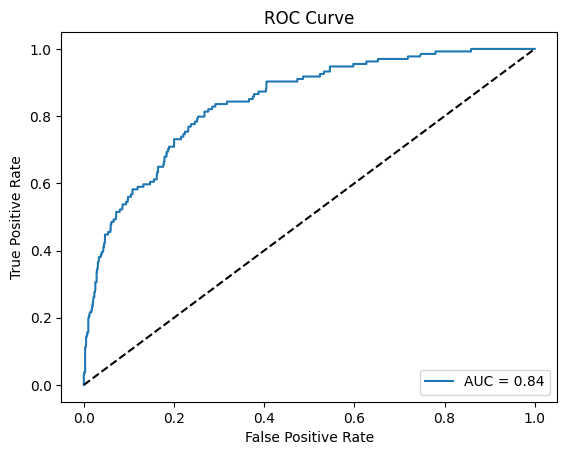

In [139]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt


df_prob = pd.DataFrame()
print([y[1] for y in y_prob])
print(y_test.values)
df_prob['positive'] = [y[1] for y in y_prob]

df_prob['output'] = y_test.values
df_prob.to_csv('output.csv')
# Compute the ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, 1])
auc_score = roc_auc_score(y_test, y_prob[:, 1])

# Plot the ROC curve
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [23]:
from imblearn.over_sampling import SMOTE

clf = xgboost.XGBClassifier()
smote = SMOTE()

X_smote, y_smote = smote.fit_resample(X, y)
clf = xgboost.XGBClassifier()

skf = StratifiedKFold(n_splits=10)

y_ = cross_val_predict(clf,X_smote,y_smote, cv=skf)
y_
print(accuracy_score(y_smote,y_))
print(precision_score(y_smote,y_, average="binary", pos_label=1.0))
print(recall_score(y_smote,y_, average="binary", pos_label=1.0))
confusion_matrix(y_smote,y_)


0.8644203129990419
0.8274344748421657
0.92089854146705


array([[7589, 1804],
       [ 743, 8650]])

In [24]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42, replacement=True)# fit predictor and target variable
x_rus, y_rus = rus.fit_resample(X, y)
clf = xgboost.XGBClassifier()

skf = StratifiedKFold(n_splits=10)

y_ = cross_val_predict(clf,x_rus,y_rus, cv=skf)
y_
print(accuracy_score(y_rus,y_))
print(precision_score(y_rus,y_, average="binary", pos_label=1.0))
print(recall_score(y_rus,y_, average="binary", pos_label=1.0))
confusion_matrix(y_rus,y_)


0.5948372615039281
0.600715137067938
0.5656565656565656


array([[556, 335],
       [387, 504]])